# Results Analysis

In [107]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time
from datetime import timedelta

### Load dataset

In [108]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(139678, 535)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [109]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.8 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

In [110]:
splitting_time

datetime.datetime(2014, 4, 17, 0, 0)

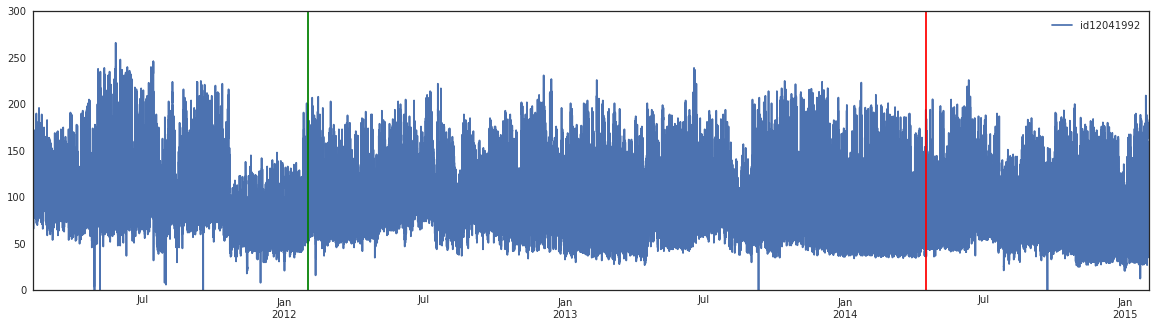

In [111]:
f = original_data[["id12041992"]].plot(figsize=(20,5)) 
original_data.iloc(splitting_point)
f.axvline(start_time, color='g')
f.axvline(splitting_time, color='r')

# Define Machine Learning Models and Data Sets

In [112]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
import regression_metrics as additional_metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score
#from neural_network import PyBrainNN

## Creating Feature Sets

In [113]:
autoregressive_ftrs = ['measurement', 'shifted_measurement_1d', 'shifted_measurement_2d', 'shifted_measurement_1w', 
                       'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                       'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                       'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                       'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_ftrs =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_ftrs =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_ftrs =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay', 't2m_termin_roll_mean_m', 'shifted_Holiday', 
              'shifted_energija_gl', 'shifted_DayOfWeek', 'shifted_t2m_termin', 'p_roll_var_d', 'shifted_measurement_2d', 
              'measurement_roll_mean_m', 'p_roll_mean_m', 'rh_termin_roll_mean_w']

top10_ftrs = ['shifted_measurement_1w', 'shifted_measurement_1d', 'measurement_roll_mean_d', 'measurement', 
              'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_max2_w', 'shifted_BusinessDay', 
              'measurement_roll_mean_w', 'shifted_HourOfDay']

In [114]:
all_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_wc_wf_ftrs = autoregressive_ftrs + wetaher_current_ftrs + weather_forecasted_ftrs
ar_wc_dt_ftrs = autoregressive_ftrs + wetaher_current_ftrs + date_time_ftrs 
ar_wf_dt_ftrs = autoregressive_ftrs + weather_forecasted_ftrs + date_time_ftrs 
ar_dt_ftrs = autoregressive_ftrs + date_time_ftrs 
ar_ftrs = autoregressive_ftrs
top20_ftrs = top20_ftrs
top10_ftrs = top10_ftrs

## Prediction Results

In [115]:
class NaiveModel:
    
    def __init__(self, target):
        self.target = target

In [116]:
horizons = range(1,25)

baselines = [{'name': "Last value", 'init': "NaiveModel('measurement')"},
             {'name': "Previous day", 'init': "NaiveModel('shifted_measurement_1d')"},
             {'name': "Previous week", 'init': "NaiveModel('shifted_measurement_1w')"},
             #{'name': "Measurement average", 'init': "NaiveModel('measurement_avr')"},
            ]

models = [#{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          #{'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': "Baselines", 'ftrs': ar_ftrs},
             #{'name': "AR", 'ftrs': ar_ftrs},
             #{'name': "AR_WC_WF", 'ftrs': ar_wc_wf_ftrs},
             #{'name': "AR_DT", 'ftrs': ar_dt_ftrs},             
             #{'name': "AR_WC_DT", 'ftrs': ar_wc_dt_ftrs},
             #{'name': "AR_WF_DT", 'ftrs': ar_wf_dt_ftrs},    
             #{'name': "ALL", 'ftrs': all_ftrs},
             {'name': "TOP_20", 'ftrs': top20_ftrs},
             #{'name': "TOP_10", 'ftrs': top10_ftrs},
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 #{'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
                 {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
                 {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [117]:
results_df = pd.DataFrame()

In [119]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[],[]], names=['horizon', 'testing_day','dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

#results_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[]], names=['horizon', 'ts']))
results_df = pd.DataFrame()

output_file_name = "results_id12041992.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#horizons = [2, 10]
horizons = [20]
#horizons = range(1,25)


def start_prediction_valuation(verbose=False):
    
    arr = []

    #sensor_list = list(data)[:15] # Sensor ids (30)
    #sensor_list = ['id14061721', 'id14061674', 'id14061709']
    #sensor_list = ['id14061721']
    sensor_list = ['id12041992']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_ftrs_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_ftrs = [col for col in list(data) if col not in sensor_ftrs_to_drop]
        sensor_data = data[sensor_data_ftrs]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        # Compute localized average
        average = sensor_data.groupby([sensor_data.index.dayofweek.values, sensor_data.index.time])['measurement'].mean()
        sensor_data = sensor_data.join(pd.DataFrame(average).rename(columns={"measurement":"measurement_avr"}), 
                         on=[sensor_data.index.dayofweek.values, sensor_data.index.time], how = 'left')
        
        #for horizon in range (1,25):
        for horizon in horizons:

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(-1 * horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime
            
            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            #splitting_point = int(0.8 * data.shape[0]) # this is the reason for differences in baseline results (we use original_data in first which is wrong)
            #original_splitting_time = data.iloc[[splitting_point]].index.to_pydatetime()[0] # here as well
            splitting_point = int(0.8 * original_data.shape[0])
            original_splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
            splitting_time = original_splitting_time.replace(hour=0, minute=0, second=0, microsecond=0) # setting to middnight
            latest_time = data.iloc[[-1]].index.to_pydatetime()[0]
            
            
            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]
            
            # Create training vectors
            X_train = training_data[ar_wf_dt_ftrs].values
            y_train = training_data[["shifted_measurement"]].values.ravel()
            #print "Using dummy features:", X_train.shape

            # Create testing vectors
            X_test = testing_data[ar_wf_dt_ftrs].values
            y_test = testing_data[["shifted_measurement"]].values.ravel()
            
            # Initializing model
            mdl = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=16)
            mdl.fit(X_train,y_train)
            pred = mdl.predict(X_test)
            

            # Prepare results df
            results_df = testing_data[["shifted_measurement"]]
            results_df.rename(columns={"shifted_measurement":"true"}, inplace=True)

            results_df['last value'] = testing_data[["measurement"]]
            results_df['previous day'] = testing_data[["shifted_measurement_1d"]]
            results_df['previous week'] = testing_data[["shifted_measurement_1w"]]           
            
            results_df['offline'] = mdl.predict(X_test)
            results_df['batch'] = np.nan
            
            arr.append(results_df)
            
            while (splitting_time < latest_time):
                                
                eval_start_time = splitting_time
                splitting_time = splitting_time + timedelta(days=1)
                eval_end_time = splitting_time
                    
                # Split Training and Testing set
                training_data = sensor_data[:eval_start_time - timedelta(minutes=15)]
                testing_data = sensor_data[eval_start_time:eval_end_time]
                
                # init temoporary batch datafreame
                batch_df_temp = pd.DataFrame(index = testing_data.index)

                # Create dummy feature vector for linear regression
                sensor_data_dummy = sensor_data.join(pd.get_dummies(sensor_data['shifted_HourOfDay'], 
                        prefix='dummy_shifted_HourOfDay').join(pd.get_dummies(sensor_data['shifted_DayOfWeek'], 
                        prefix='dummy_shifted_DayOfWeek').join(pd.get_dummies(sensor_data['shifted_Month'], 
                        prefix='dummy_shifted_Month'))))
                #sensor_data_dummy.dropna(inplace=True)
                dummy_ftrs = [col for col in list(sensor_data_dummy.columns) if col.startswith('dummy')]
                training_data_dummy = sensor_data_dummy[:eval_start_time - timedelta(minutes=15)]
                testing_data_dummy = sensor_data_dummy[eval_start_time:eval_start_time]
                
                if verbose: print "\n\t\t-->{} ({})".format('Evaluation', splitting_time)
                
                for data_set in data_sets:              
                
                    # Create training vectors
                    X_train = training_data[data_set['ftrs']].values
                    y_train = training_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_train.shape

                    # Create testing vectors
                    X_test = testing_data[data_set['ftrs']].values
                    y_test = testing_data[["shifted_measurement"]].values.ravel()
                    #print "Using dummy features:", X_test.shape

                    if verbose: print "\t\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], 
                                                                                              X_train.shape, y_train.shape)

                    if data_set['name'] == "Baselines":
                        for baseline in baselines:

                            if verbose: print "\t\t\t\t-->Computing {}".format(baseline['name'])
                            bl = eval(baseline['init'])

                            for metric in error_metrics:
                                if metric['short'] == 'MASE':
                                    error = metric['function'](y_train, training_data[["measurement"]].values.ravel(),
                                                               y_test, testing_data[bl.target])
                                else:
                                    error = metric['function'](y_test, testing_data[bl.target])

                                validation_df.loc[(horizon, splitting_time, baseline['name'], data_set['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

                    else:    
                        for model in models: 
                            # Initializing model
                            mdl = eval(model['init'])

                            # Model leraning
                            start = time.time() # Start measuring time
                            if model['name'] == "Ridge Regression":
                                mdl.fit(X_train_dummy, y_train_dummy)
                            else:
                                mdl.fit(X_train,y_train)
                                
                            # predictions
                            pred = mdl.predict(X_test)
                            batch_df_temp['batch'] = pred
                                
                            runtime = time.time() - start # Calculate runtime
                            
                            results_df.update(batch_df_temp)

                            if verbose: print "\t\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                            for metric in error_metrics:
                                #print "\t-->Error metric: {}".format(metric['name'])

                                if model['name'] == "Ridge Regression":
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train_dummy, training_data[["measurement"]].values.ravel(),
                                                                   y_test_dummy, mdl.predict(X_test_dummy))
                                    else:
                                        error = metric['function'](y_test_dummy, mdl.predict(X_test_dummy))

                                else: 
                                    if metric['short'] == 'MASE':
                                        error = metric['function'](y_train, training_data[["measurement"]].values.ravel(), 
                                                                   y_test, mdl.predict(X_test))
                                    else:
                                        error = metric['function'](y_test, mdl.predict(X_test))

                                #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                                validation_df.loc[(horizon, splitting_time, data_set['name'], model['name']), (sensor_name, metric['short'])] = error

                                if verbose: print "\t\t\t\t\t-->{}: {:.3f}".format(metric['short'], error)

            
                #print results_df
        
        all_results = pd.concat(arr, keys=horizons)
        all_results.index.set_names(['horizons', 'values'], inplace=True)

        print all_results
        
        all_results.to_csv(output_file_path)
        
start_prediction_valuation(verbose=True)
#start_prediction_valuation(verbose=False)
#validation_df

print "Finished."

#output_file_name = "testni_eval_top20_id12041992.csv"
#output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

#validation_df.to_csv(output_file_path)

Working with sensor: id12041992

	-->Prediction horizont: 20h. Shifting runtime: 1.01s

C:\Python27\lib\site-packages\ipykernel\__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\ipykernel\__main__.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\ipykernel\__main__.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\sit



		-->Evaluation (2014-04-18 00:00:00)
			-->Dataset: Baselines. X_train: (77376L, 16L), y_train: (77376L,)
				-->Computing Last value
					-->R2: -0.704
					-->MAE: 32.122
					-->MAPE: 39.025
					-->MASE: 0.978
				-->Computing Previous day
					-->R2: 0.772
					-->MAE: 11.740
					-->MAPE: 12.274
					-->MASE: 0.358
				-->Computing Previous week
					-->R2: 0.629
					-->MAE: 15.798
					-->MAPE: 16.443
					-->MASE: 0.481
			-->Dataset: TOP_20. X_train: (77376L, 20L), y_train: (77376L,)
				-->Training model: Random Forest, runtime: 8.41s
					-->R2: 0.859
					-->MAE: 9.318
					-->MAPE: 9.717
					-->MASE: 0.284

		-->Evaluation (2014-04-19 00:00:00)
			-->Dataset: Baselines. X_train: (77472L, 16L), y_train: (77472L,)
				-->Computing Last value
					-->R2: -3.180
					-->MAE: 43.401
					-->MAPE: 56.141
					-->MASE: 1.322
				-->Computing Previous day
					-->R2: -0.725
					-->MAE: 23.931
					-->MAPE: 29.281
					-->MASE: 0.729
				-->Computing Previous week
					-->R2:

C:\Python27\lib\site-packages\ipykernel\__main__.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [120]:
# read from csv
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)
test =  pd.read_csv(input_file_path, index_col=[0,1])

test

true  last value  previous day  previous week  \
horizons values                                                                
20       2014-04-17 00:00:00  127.0        71.0         129.0          115.1   
         2014-04-17 00:15:00  122.2        72.1         124.2          148.0   
         2014-04-17 00:30:00  133.4        66.3         114.0          136.2   
         2014-04-17 00:45:00  124.2        66.2         111.5          113.0   
         2014-04-17 01:00:00  126.0        53.0         117.0          121.8   
         2014-04-17 01:15:00  105.1        43.1         102.1          109.0   
         2014-04-17 01:30:00   95.0        40.1          98.1          102.1   
         2014-04-17 01:45:00   83.2        37.1          98.1          100.1   
         2014-04-17 02:00:00   90.3        42.5         102.0          101.1   
         2014-04-17 02:15:00   79.1        38.1          99.5           95.1   
         2014-04-17 02:30:00   87.0        40.0          85.0           97.1   
         2014-04-17 02:45:00   79.1        37.1          88.1           91.0   
         2014-04-17 03:00:00   76.1        40.1          87.0           89.2   
         2014-04-17 03:15:00   71.5        38.3          86.6           79.2   
         2014-04-17 03:30:00   73.1        39.1          73.0           82.2   
         2014-04-17 03:45:00   68.1        36.1          75.2           84.4   
         2014-04-17 04:00:00   74.0        41.0          71.0           76.1   
         2014-04-17 04:15:00   69.3        50.2          72.1           81.0   
         2014-04-17 04:30:00   52.1        70.4          66.3           79.2   
         2014-04-17 04:45:00   49.1        82.2          66.2           81.0   
         2014-04-17 05:00:00   55.1        65.0          53.0           82.1   
         2014-04-17 05:15:00   49.1        71.2          43.1           66.0   
         2014-04-17 05:30:00   52.0        74.2          40.1           66.2   
         2014-04-17 05:45:00   51.5        65.1          37.1           64.3   
         2014-04-17 06:00:00   48.1        76.1          42.5           66.1   
         2014-04-17 06:15:00   50.1        98.0          38.1           60.4   
         2014-04-17 06:30:00   47.3       119.0          40.0           65.2   
         2014-04-17 06:45:00   51.1       112.0          37.1           64.0   
         2014-04-17 07:00:00   44.1       124.1          40.1           48.2   
         2014-04-17 07:15:00   50.1       151.0          38.3           51.0   
...                             ...         ...           ...            ...   
         2015-01-31 20:30:00  104.3       130.6         101.4           87.3   
         2015-01-31 20:45:00  113.4       147.6         103.4           91.7   
         2015-01-31 21:00:00  110.3       122.0         103.3           96.1   
         2015-01-31 21:15:00  110.9       112.3         127.7           98.8   
         2015-01-31 21:30:00  127.4       105.7         143.1          103.0   
         2015-01-31 21:45:00  144.3       104.7         110.6          140.9   
         2015-01-31 22:00:00  129.7       106.6         105.9          125.9   
         2015-01-31 22:15:00  112.8       135.8         116.1           93.0   
         2015-01-31 22:30:00  112.2       121.0         111.7          105.3   
         2015-01-31 22:45:00  115.9        97.5         114.1           96.3   
         2015-01-31 23:00:00  104.7        96.7         138.8           96.4   
         2015-01-31 23:15:00  131.8        92.2         130.2           98.3   
         2015-01-31 23:30:00  137.3        91.6         113.4          145.6   
         2015-01-31 23:45:00  105.7       105.2         105.3          120.0   
         2015-02-01 00:00:00   99.6       121.9         111.1           96.8   
         2015-02-01 00:15:00   98.0        90.2         114.8           97.6   
         2015-02-01 00:30:00  104.8        82.2         130.6           90.1   
         2015-02-01 00:45:00  1

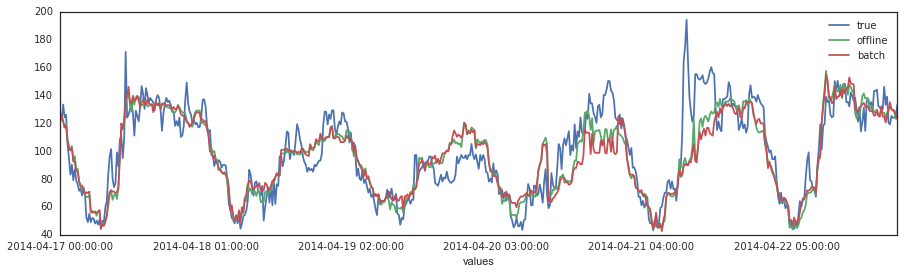

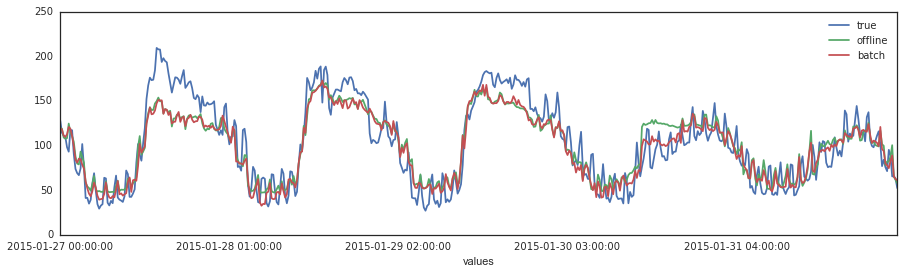

In [104]:
test.loc[20]['2014-04-17 00:00:00':'2014-04-23 00:00:00'][['true','offline','batch']].plot(figsize=(15,4))
test.loc[20]['2015-01-27 00:00:00':'2015-02-01 23:59:00'][['true','offline','batch']].plot(figsize=(15,4))

In [368]:
test.index.to_datetime().dayofyear

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


Int64Index([107, 107, 107, 107, 107, 107, 107, 107, 107, 107,
            ...
             32,  32,  32,  32,  32,  32,  32,  32,  32,  32],
           dtype='int64', length=27932)

In [450]:
a=test.groupby(test.index.to_datetime().dayofyear, sort=False).mean()
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  if __name__ == '__main__':


,true,last value,previous day,previous week,offline,batch
107,107.063542,105.942708,104.995833,103.214583,104.829689,104.915682
108,100.204167,108.309375,107.063542,104.943750,100.034430,100.044284
109,89.452083,89.281250,100.204167,91.144792,89.992677,89.982633
110,78.502083,79.286458,89.452083,98.927083,86.927859,89.820944
111,104.895833,95.008333,78.502083,99.862500,90.637076,87.021699
112,110.705208,111.708333,104.895833,99.969792,105.252439,104.295775
113,108.936458,108.089583,110.705208,104.995833,108.879269,110.084351
114,107.834375,109.010417,108.936458,107.063542,109.377374,110.652701
115,107.233333,114.827083,107.834375,100.204167,103.359870,104.593433
116,86.413542,90.683333,107.233333,89.452083,93.041639,93.236689


In [38]:
from sklearn.metrics import r2_score

def r2( g ):
    r2_lv = r2_score( g['true'], g['last value'] )
    r2_pd = r2_score( g['true'], g['previous day'] )
    r2_pw = r2_score( g['true'], g['previous week'] )
    r2_offline = r2_score( g['true'], g['offline'] )
    r2_batch = r2_score( g['true'], g['batch'] )
    return pd.Series( dict(  r2_lv=r2_lv, r2_pd=r2_pd, r2_pw=r2_pw, r2_offline=r2_offline, r2_batch=r2_batch ) )

#subset = test['2014-04-17 00:00:00':'2014-04-27 00:00:00']
subset = test.loc[20]['2015-01-05 00:00:00':'2015-02-01 23:59:00']
#subset = test['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)
a

C:\Python27\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


,r2_batch,r2_lv,r2_offline,r2_pd,r2_pw
5,0.723645,-0.570706,0.753277,0.608645,0.201785
6,0.695740,-0.981022,0.707764,0.621184,-2.496323
7,0.783763,-0.299510,0.766943,0.788527,-2.970806
8,0.882035,-0.679287,0.827702,0.721435,0.002400
9,0.769532,-2.065558,0.729472,-0.178633,0.734967
10,0.809167,-0.828385,0.726922,0.757059,0.445495
11,0.553038,0.445588,0.535448,0.181657,0.128073
12,0.729494,-0.093710,0.715340,0.673541,0.624853
13,0.671558,0.066480,0.658707,0.586806,0.600238
14,0.757539,-0.662315,0.735797,0.586304,0.645584


Bar plot for last month. Major improvement for batch is not visible.

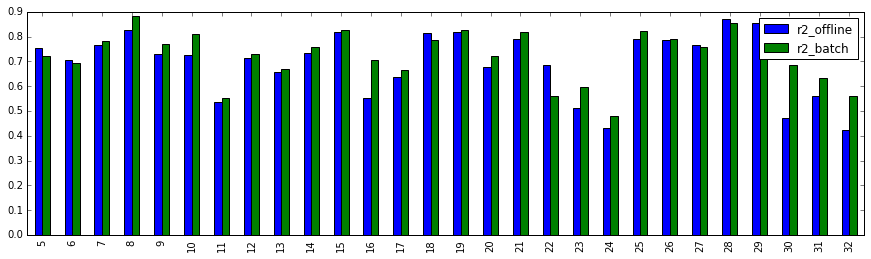

In [39]:
a[['r2_offline','r2_batch']].plot( kind='bar', figsize=(15,4))

Diff is not very informative

C:\Python27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


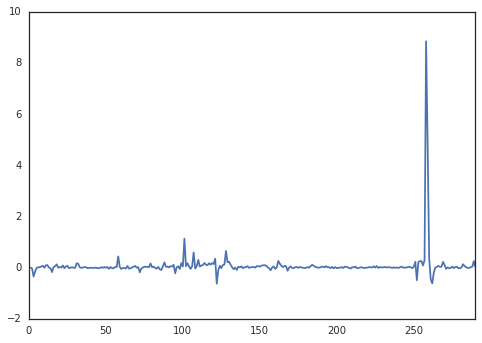

In [661]:
b['diff'] = b['r2_batch'] - b['r2_offline']
b.reset_index()['diff'].plot()

Scatter plot for entire testing dataset.

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


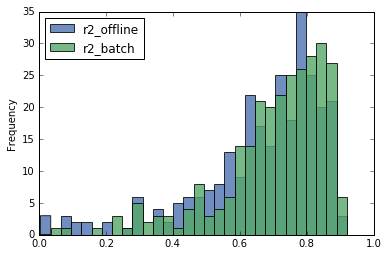

In [46]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]
#a[['r2_offline','r2_batch']].plot( kind='hist', figsize=(15,4))
#a[['r2_offline','r2_batch']].hist(figsize=(15,4), bins=20)
#a[['r2_offline','r2_batch']].plot.hist(bins=30)
b[b > 0].plot.hist(bins=30, alpha=0.8)

C:\Python27\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


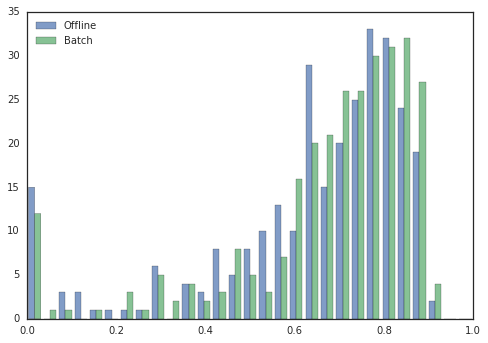

In [60]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]

c = b[b > 0].reset_index()[['r2_offline','r2_batch']]

c = c.fillna(0)

x = c["r2_offline"].values
y = c["r2_batch"].values
data = np.vstack([x, y]).T
bins = np.linspace(0, 1, 30)

plt.hist(data, bins, alpha=0.7, label=['Offline', 'Batch'])
plt.legend(loc='upper left')
plt.show()

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


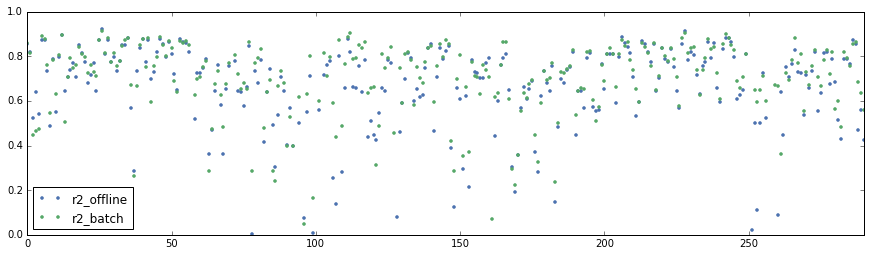

In [49]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]

#a[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='*')
b[b > 0].reset_index()[['r2_offline','r2_batch']].plot( figsize=(15,4), marker='.', linestyle='')

Scatter plot for entire testing dataset with regression plot trend, showing that Batch is better. Unfortunatelly the trend is downword. Maybe try with different sensor.

C:\Python27\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)


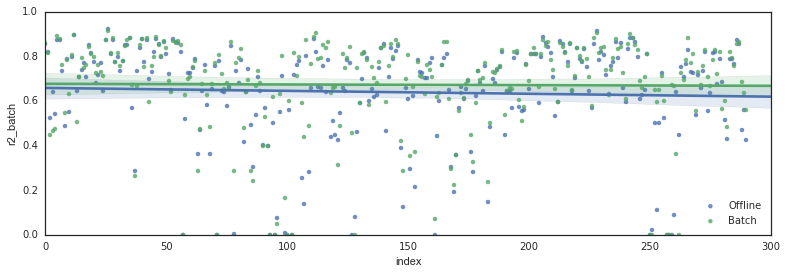

In [99]:
import seaborn as sns

sns.set_style("white")

subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(r2)

b = a[['r2_offline','r2_batch']]

#c = b.reset_index()[['r2_offline','r2_batch']]
c = b[b > 0].reset_index()[['r2_offline','r2_batch']]
c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="r2_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,1))
sns.regplot(y="r2_batch", x="index", data=c, label='Batch');

plt.legend(loc='lower right')
plt.show()

In [100]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

Offline slope: -0.000130665701841
Batch slope: -3.00036993185e-05


In [74]:
## MAPE analysis

In [56]:
import regression_metrics as additional_metrics

def mape(g):
    mape_lv = additional_metrics.mean_absolute_percentage_error( g['true'], g['last value'] )
    mape_pd = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous day'] )
    mape_pw = additional_metrics.mean_absolute_percentage_error( g['true'], g['previous week'] )
    mape_offline = additional_metrics.mean_absolute_percentage_error( g['true'], g['offline'] )
    mape_batch = additional_metrics.mean_absolute_percentage_error( g['true'], g['batch'] )
    return pd.Series( dict(  mape_lv=mape_lv, mape_pd=mape_pd, mape_pw=mape_pw, mape_offline=mape_offline, mape_batch=mape_batch ) )

C:\Python27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  from ipykernel import kernelapp as app


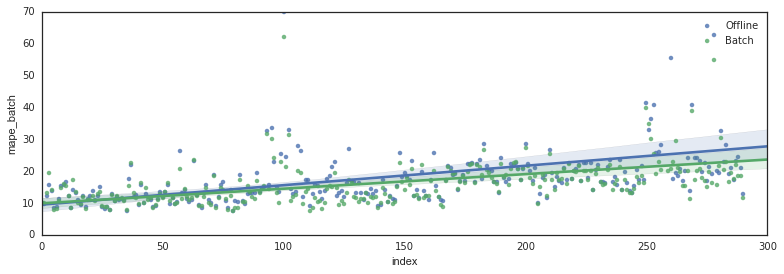

In [89]:
subset = test.loc[20]['2014-04-17 00:00:00':'2015-02-01 23:59:00']
a=subset.groupby(subset.index.to_datetime().dayofyear, sort=False).apply(mape)
a

b = a[['mape_offline','mape_batch']]

c = b[b > 0].reset_index()[['mape_offline','mape_batch']]
#c = c.fillna(0)
c['index'] = c.index

plt.figure(figsize=(13,4))
#sns.pairplot(c, size=5, aspect=.8, kind="reg");
g = sns.regplot(y="mape_offline", x="index", data=c, label='Offline');
g.set(xlim=(0,300), ylim=(0,70))
sns.regplot(y="mape_batch", x="index", data=c, label='Batch');

plt.legend(loc='upper right')
plt.show()

In [90]:
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[0].get_xdata(),y=g.get_lines()[0].get_ydata())
print "Offline slope:", slope

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=g.get_lines()[1].get_xdata(),y=g.get_lines()[1].get_ydata())
print "Batch slope:", slope

Offline slope: 0.0608984822637
Batch slope: 0.04574173323


## Future work

- more horizons
- more sensors
- online approach